<a href="https://colab.research.google.com/github/data-alch3m1st/PyTorch_tinkering/blob/main/0x02_PyTorch__multiclassModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import dependencies
import torch
import torch.nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

In [61]:
# Set the hyperparameters for data creation
NUM_CLASSES = 5
NUM_FEATURES = 2
RANDOM_SEED = 27

# 1. Create multi-class data
X_blob, y_blob = make_blobs(
    n_samples=1000
    , n_features=NUM_FEATURES # X features
    , centers=NUM_CLASSES # y labels
    , cluster_std=1.5 # give the clusters a little shake up (try changing this to 1.0, the default)
#     , cluster_std=1.75
    , random_state=RANDOM_SEED
)

In [62]:
# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5], y_blob[:5])

tensor([[ 7.4993, -8.2001],
        [ 7.8068,  1.0832],
        [-1.3114,  3.5973],
        [10.6766, -3.9457],
        [ 7.4921,  7.1723]]) tensor([3, 4, 0, 3, 1])


In [63]:
# 3. Split into train and test sets
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(
    X_blob, y_blob
    , test_size=0.2
    , random_state=RANDOM_SEED
)

X_blob_train.shape, X_blob_test.shape, y_blob_train.shape, y_blob_test.shape

(torch.Size([800, 2]),
 torch.Size([200, 2]),
 torch.Size([800]),
 torch.Size([200]))

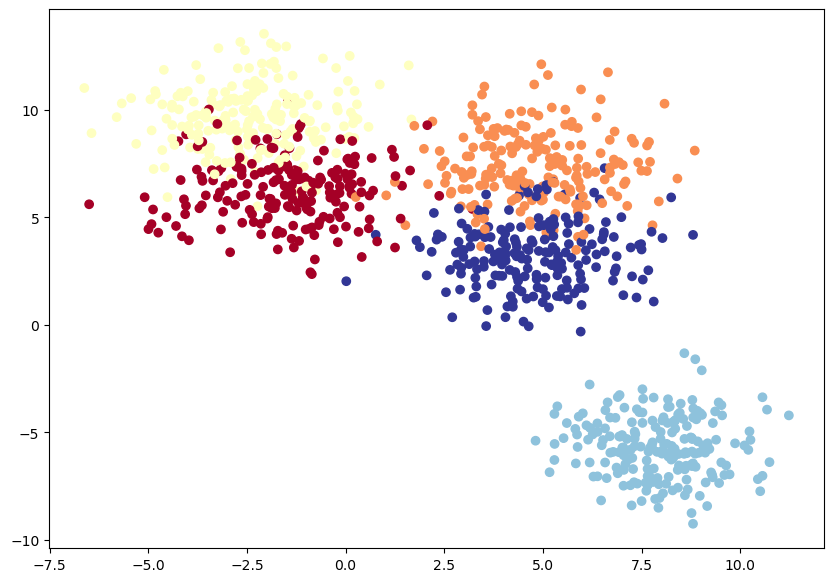

In [64]:
# 4. Plot data
plt.figure(figsize=(10, 7))
plt.scatter(
    X_blob[:, 0], X_blob[:, 1]
    , c=y_blob, cmap=plt.cm.RdYlBu
    );

In [6]:
# Create device agnostic code (for either colab/win or mac; comment out the one you are NOT using;)

# If on Colab or a Windows machine:
# device = "cuda" if torch.cuda.is_available() else "cpu"
# device

# If on MacBook:
if torch.cuda.is_available():
    device = "cuda" # Use NVIDIA GPU (if available)
elif torch.backends.mps.is_available():
    device = "mps" # Use Apple Silicon GPU (if available)
else:
    device = "cpu" # Default to CPU if no GPU is available
    
print(device)

mps


In [65]:
from torch import nn

# Build model
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        """Initializes all required hyperparameters for a multi-class classification model.

        Args:
            input_features (int): Number of input features to the model.
            out_features (int): Number of output features of the model
              (how many classes there are).
            hidden_units (int): Number of hidden units between layers, default 8.
        """
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units)
            # v- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            , nn.ReLU() 
            , nn.Linear(in_features=hidden_units, out_features=hidden_units)
            # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            , nn.ReLU() 
            , nn.Linear(in_features=hidden_units, out_features=output_features) # how many classes are there?
        )

    def forward(self, x):
        return self.linear_layer_stack(x)

In [66]:
# Create an instance of BlobModel and send it to the target device
model_4 = BlobModel(
    input_features=NUM_FEATURES
    , output_features=NUM_CLASSES
    , hidden_units=8
    ).to(device)

model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=5, bias=True)
  )
)

In [67]:
# Create loss and optimizer
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(
    model_4.parameters()
    , lr=0.1) # exercise: try changing the learning rate here and seeing what happens to the model's performance

In [68]:
# Perform a single forward pass on the data (we'll need to put it to the target device for it to work)
model_4(X_blob_train.to(device))[:5]

tensor([[ 0.0872, -0.0830,  0.4758, -0.6259, -0.6546],
        [ 0.0921, -0.0798,  0.4576, -0.5876, -0.6113],
        [ 0.0976, -0.0815,  0.4463, -0.5622, -0.5868],
        [ 0.3809, -0.0688,  0.4571, -0.2146, -0.2934],
        [ 0.0675, -0.0827,  0.5258, -0.7353, -0.7679]], device='mps:0',
       grad_fn=<SliceBackward0>)

In [69]:
# How many elements in a single prediction sample?
model_4(X_blob_train.to(device))[0].shape, NUM_CLASSES

(torch.Size([5]), 5)

In [70]:
# Make prediction logits with model
y_logits = model_4(X_blob_test.to(device))

# Perform softmax calculation on logits across dimension 1 to get prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[ 0.0692, -0.0822,  0.5205, -0.7240, -0.7556],
        [ 0.0826,  0.0283,  0.2921, -0.2718, -0.1675],
        [ 0.3679, -0.0690,  0.4388, -0.2004, -0.2733],
        [ 0.2229, -0.0457,  0.2430, -0.0437, -0.0290],
        [ 0.1074,  0.0085,  0.2632, -0.2004, -0.1144]], device='mps:0',
       grad_fn=<SliceBackward0>)
tensor([[0.2315, 0.1989, 0.3635, 0.1047, 0.1014],
        [0.2146, 0.2032, 0.2646, 0.1505, 0.1671],
        [0.2623, 0.1694, 0.2816, 0.1486, 0.1381],
        [0.2310, 0.1766, 0.2357, 0.1770, 0.1796],
        [0.2169, 0.1965, 0.2535, 0.1594, 0.1737]], device='mps:0',
       grad_fn=<SliceBackward0>)


In [71]:
# Sum the first sample output of the softmax activation function
torch.sum(y_pred_probs[0])

tensor(1., device='mps:0', grad_fn=<SumBackward0>)

In [72]:
# Which class does the model think is *most* likely at the index 0 sample?
print(y_pred_probs[0])
print(torch.argmax(y_pred_probs[0]))

tensor([0.2315, 0.1989, 0.3635, 0.1047, 0.1014], device='mps:0',
       grad_fn=<SelectBackward0>)
tensor(2, device='mps:0')


In [15]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

In [16]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

In [ ]:
# Fit the model
torch.manual_seed(27)

# Set number of epochs
epochs = 1500

# Put data to target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    ### Training
    model_4.train()

    # 1. Forward pass
    y_logits = model_4(X_blob_train) # model outputs raw logits
    y_pred = torch.softmax(
        y_logits, dim=1
        ).argmax(dim=1) # go from logits -> prediction probabilities -> prediction labels
    # print(y_logits)

    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_blob_train)
    acc = accuracy_fn(
        y_true=y_blob_train
        , y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_4.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_4(X_blob_test)
      test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
      # 2. Calculate test loss and accuracy
      test_loss = loss_fn(test_logits, y_blob_test)
      test_acc = accuracy_fn(
          y_true=y_blob_test
          , y_pred=test_pred)

    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.33149, Acc: 87.50% | Test Loss: 0.28289, Test Acc: 90.00%
Epoch: 100 | Loss: 0.32295, Acc: 88.25% | Test Loss: 0.27389, Test Acc: 89.50%
Epoch: 200 | Loss: 0.31612, Acc: 88.62% | Test Loss: 0.26685, Test Acc: 89.50%
Epoch: 300 | Loss: 0.30994, Acc: 88.62% | Test Loss: 0.26030, Test Acc: 90.00%
Epoch: 400 | Loss: 0.30461, Acc: 89.25% | Test Loss: 0.25470, Test Acc: 90.00%
Epoch: 500 | Loss: 0.30017, Acc: 89.00% | Test Loss: 0.25008, Test Acc: 90.00%
Epoch: 600 | Loss: 0.29596, Acc: 89.25% | Test Loss: 0.24571, Test Acc: 90.50%
Epoch: 700 | Loss: 0.29216, Acc: 89.50% | Test Loss: 0.24157, Test Acc: 90.50%
Epoch: 800 | Loss: 0.28949, Acc: 89.75% | Test Loss: 0.23903, Test Acc: 90.50%
Epoch: 900 | Loss: 0.28547, Acc: 89.75% | Test Loss: 0.23430, Test Acc: 90.50%


In [49]:
# Make predictions
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test)

# View the first 10 predictions
y_logits[:10]

tensor([[ 0.5230, -0.6577,  0.5371, -1.0435],
        [ 0.2231, -0.4368,  0.2175, -0.7131],
        [ 0.5219, -0.6570,  0.5360, -1.0423],
        [ 0.5238, -0.6583,  0.5379, -1.0442],
        [ 0.5235, -0.6581,  0.5376, -1.0439],
        [ 0.5236, -0.6582,  0.5377, -1.0440],
        [-0.9583,  0.4214, -1.0328,  0.5840],
        [ 0.5107, -0.6494,  0.5246, -1.0303],
        [-1.0207,  0.4621, -1.0996,  0.6571],
        [ 0.5232, -0.6579,  0.5373, -1.0437]], device='mps:0')

In [50]:
# Turn predicted logits in prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)

# Turn prediction probabilities into prediction labels
y_preds = y_pred_probs.argmax(dim=1)

# Compare first 10 model preds and test labels
print(f"Predictions: {y_preds[:10]}\nLabels: {y_blob_test[:10]}")
print(f"Test accuracy: {accuracy_fn(y_true=y_blob_test, y_pred=y_preds)}%")

Predictions: tensor([2, 0, 2, 2, 2, 2, 3, 2, 3, 2], device='mps:0')
Labels: tensor([2, 0, 0, 2, 0, 2, 1, 0, 3, 2], device='mps:0')
Test accuracy: 49.5%


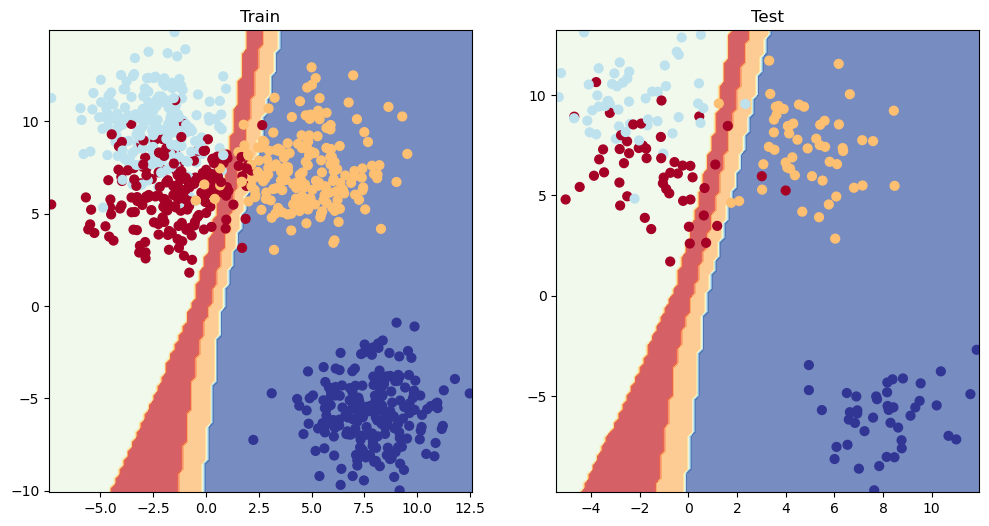

In [51]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)